<a href="https://colab.research.google.com/github/T-biohazard/Data_Science_Projects/blob/main/Explainable%20Ai_imlementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git


fatal: destination path 'pytorch-grad-cam' already exists and is not an empty directory.


In [2]:
%cd pytorch-grad-cam
!pip install .


/content/pytorch-grad-cam
Processing /content/pytorch-grad-cam
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.2-py3-none-any.whl size=38146 sha256=fff6584cf7d13489dbeaa4f641b5c1211bb83d7fa55c00f7ece703817fa745e4
  Stored in directory: /root/.cache/pip/wheels/e8/a3/17/3f39a99ce2c5dd547cf925a92d18d2a67b31877da39af114f0
Successfully built grad-cam
  Attempting uninstall: grad-cam
    Found existing installation: grad-cam 1.5.2
    Uninstalling grad-cam-1.5.2:
      Successfully uninstalled grad-cam-1.5.2


In [ ]:
# import os
# os._exit(00)


In [1]:
!pip install pytorch-grad-cam # install the missing package
import torch
from torch import nn
from torchvision import models, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from pytorch_grad_cam import GradCAM # now this import should work
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


In [2]:
# 1. Load Pretrained Model
model = models.resnet50(pretrained=True)
model.eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:

# 2. Define GradCAM class (inherits from pytorch_grad_cam)
class MyGradCAM(GradCAM):
    def __init__(self, model, target_layers, reshape_transform=None):
        super(MyGradCAM, self).__init__(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

    def get_cam_weights(self, input_tensor, target_layer, target_category, activations, grads):
        if len(grads.shape) == 4:
            return np.mean(grads, axis=(2, 3))  # For 2D images
        elif len(grads.shape) == 5:
            return np.mean(grads, axis=(2, 3, 4))  # For 3D images
        else:
            raise ValueError("Invalid grads shape. Should be 4D (2D image) or 5D (3D image).")


In [4]:
# 3. Image Preprocessing Function
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
    return input_tensor


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# prompt: # 4. Load an Image
# image_path = 'path_to_your_image.jpg'  # Replace with your image path
# input_tensor = preprocess_image(image_path)
# hint input path-> drive/Drive/mango

image_path = '/content/img_0_322.jpg'  # Replace with your image path
input_tensor = preprocess_image(image_path)


In [8]:
# Convert image to numpy for visualization later
image = Image.open(image_path)
image_np = np.array(image.resize((224, 224))) / 255.0  # Normalize for visualization


In [9]:
# 5. Initialize Grad-CAM
target_layers = [model.layer4[-1]]  # Final convolutional layer of ResNet
cam = MyGradCAM(model=model, target_layers=target_layers)


In [10]:
# 6. Get CAM results
targets = [ClassifierOutputTarget(281)]  # Example target class (modify as needed)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

In [11]:
# 7. Display Grad-CAM result
grayscale_cam = grayscale_cam[0, :]  # Remove batch dimension


In [12]:
# Overlay the Grad-CAM heatmap onto the image
cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)


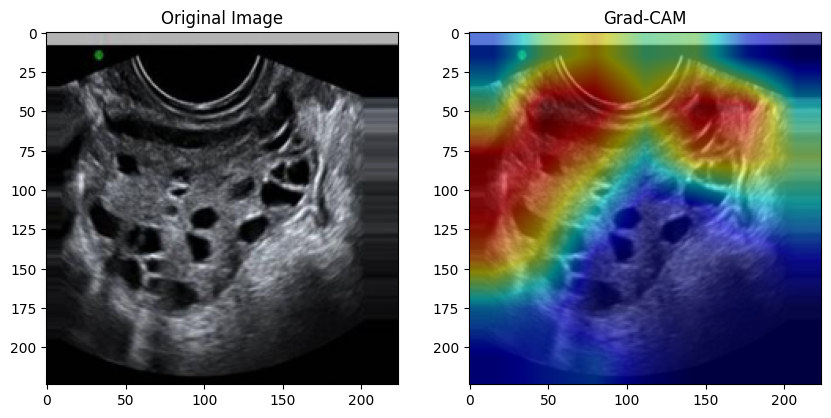

In [13]:
# 8. Display the original image and the Grad-CAM overlay
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_np)

plt.subplot(1, 2, 2)
plt.title('Grad-CAM')
plt.imshow(cam_image)

plt.show()


In [ ]:
# additional Explainable AI (XAI) approaches that can be implemented in a similar way in Colab. The approaches include:

# ScoreCAM: A variant of Grad-CAM that uses forward activation maps instead of gradients.
# Guided Backpropagation: A method that visualizes which pixels in the input image contribute most to the output.
# Integrated Gradients: A technique that computes the path integral of gradients for input feature attributions.
# 1. ScoreCAM:
# ScoreCAM uses the forward activation maps to compute the contribution of each pixel by observing how much the score changes. It doesn't rely on gradients, making it more robust.

Below, I'll add some additional Explainable AI (XAI) approaches that can be implemented in a similar way in Colab. The approaches include:

ScoreCAM: A variant of Grad-CAM that uses forward activation maps instead of gradients.
Guided Backpropagation: A method that visualizes which pixels in the input image contribute most to the output.
Integrated Gradients: A technique that computes the path integral of gradients for input feature attributions.

In [ ]:
# Assuming pytorch-grad-cam is already installed

# Import ScoreCAM
from pytorch_grad_cam import ScoreCAM




In [ ]:
# Initialize ScoreCAM
score_cam = ScoreCAM(model=model, target_layers=target_layers)

# Get ScoreCAM results
score_cam_output = score_cam(input_tensor=input_tensor, targets=targets)
score_cam_output = score_cam_output[0, :]  # Remove batch dimension

# Visualize ScoreCAM results
score_cam_image = show_cam_on_image(image_np, score_cam_output, use_rgb=True)



100%|██████████| 128/128 [08:09<00:00,  3.82s/it]


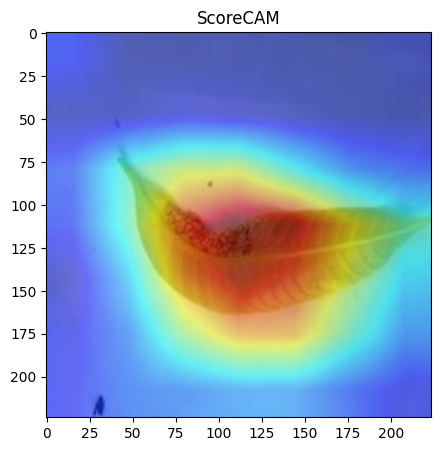

In [ ]:
# Display the ScoreCAM result
plt.figure(figsize=(10, 5))
plt.title('ScoreCAM')
plt.imshow(score_cam_image)
plt.show()

#2. Guided Backpropagation:
Guided Backpropagation is another popular technique to visualize which parts of the input image affect the decision of the neural network.

In [ ]:
import torch
from pytorch_grad_cam.utils.image import deprocess_image
from pytorch_grad_cam import GuidedBackpropReLUModel
import matplotlib.pyplot as plt

In [ ]:
# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Guided Backpropagation with the correct device
gb_model = GuidedBackpropReLUModel(model=model, device=device)

# Get the Guided Backpropagation result by passing the input_tensor directly
gb_output = gb_model(input_tensor)  # Pass input_tensor directly without keyword

# Convert to image format
gb_output = gb_output.transpose(1, 2, 0)  # Change tensor shape for visualization
gb_output = deprocess_image(gb_output)


TypeError: Invalid shape (224, 3, 224) for image data

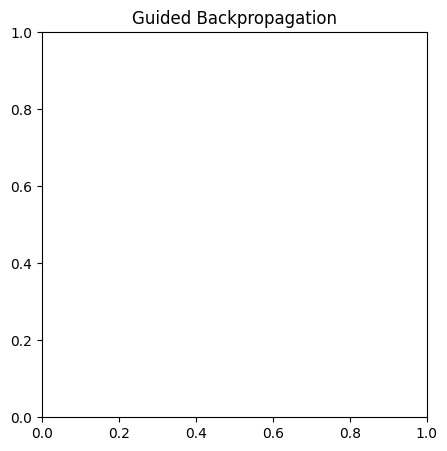

In [ ]:
# Display the Guided Backpropagation result
plt.figure(figsize=(10, 5))
plt.title('Guided Backpropagation')
plt.imshow(gb_output)
plt.show()

#3. Integrated Gradients:
Integrated Gradients works by computing the integral of gradients along the path from a baseline (typically a black image) to the input image.

In [ ]:
!pip install captum


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.7 MB/s eta 0:00:00


In [ ]:
# Import the necessary modules
import torch
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Define a baseline (black image of the same shape as input)
baseline = torch.zeros(input_tensor.shape).to(input_tensor.device)

# Compute Integrated Gradients
attr_ig, _ = ig.attribute(input_tensor, baseline, target=281, return_convergence_delta=True)

# Convert the attributions to numpy for visualization
attr_ig = attr_ig.squeeze().cpu().detach().numpy()
attr_ig = np.transpose(attr_ig, (1, 2, 0))  # Change tensor shape for visualization

# Normalize the attributions for visualization
attr_ig = (attr_ig - attr_ig.min()) / (attr_ig.max() - attr_ig.min())




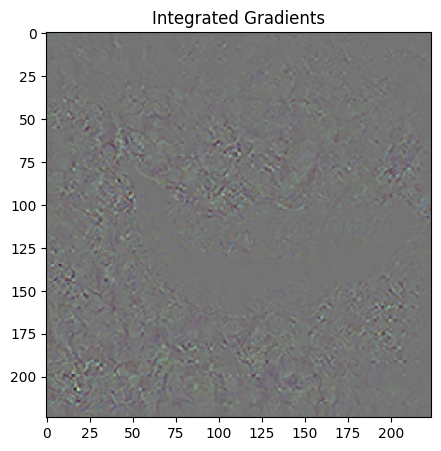

In [ ]:
# Display the Integrated Gradients result
plt.figure(figsize=(10, 5))
plt.title('Integrated Gradients')
plt.imshow(attr_ig)
plt.show()

Explanation:
ScoreCAM: Relies on forward activations to attribute importance to pixels, providing more interpretable results than Grad-CAM in some cases.
Guided Backpropagation: Only shows positive gradients, highlighting which pixels in the input image strongly affect the output.
Integrated Gradients: Uses a baseline (such as a black image) and integrates gradients to provide a detailed attribution map across input features.
Conclusion:
These approaches (ScoreCAM, Guided Backpropagation, and Integrated Gradients) are easy to implement in Colab, similar to your existing Grad-CAM setup. Each method provides a different perspective for understanding how your deep learning models make decisions. Let me know if you'd like further assistance with any of these techniques!

#Refered Site -> https://github.com/jacobgil/pytorch-grad-cam/tree/master/pytorch_grad_cam

#Extras[link text](https://)https://chatgpt.com/share/66f06ef4-e158-8008-aeeb-6b912279602c